In [1]:
import numpy as np
import numpy as cp  # no GPU, so it's been changed from 'import cupy as cp'
import matplotlib.pyplot as plt
import poppy as pp
# import lina.phase_retrieval as pr
# import organized_functions as pr
import organized_functions as pr

%reload_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\yiyan\.conda\envs\phase_retrieval\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


# Get pupil

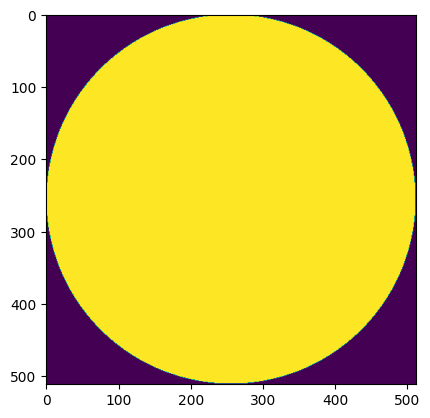

In [8]:
wavelength = 633e-9 # wavelength in meters
d_pupil = 1 # pupil diameter in meters
npix_pupil = 512 # sampling rate on a single side of the pupil

x = cp.linspace(-d_pupil / 2, d_pupil / 2, npix_pupil) # give a 1 x 512 vector in range [-d_pupil/2, d_pupil/2]
x, y = cp.meshgrid(x, x) # use 2 vectors to generate 2 mesh grids
r = cp.sqrt(x ** 2 + y ** 2) # radius

pupil = cp.ones_like(r) # create a matrix whose size and data format are similar to 'r' and value is 1
pupil[r >= d_pupil / 2] = 0 # update the pupil according to the positions obtained through 'r'

plt.imshow(pupil)
plt.show()

# Use pupil to get defocus probes

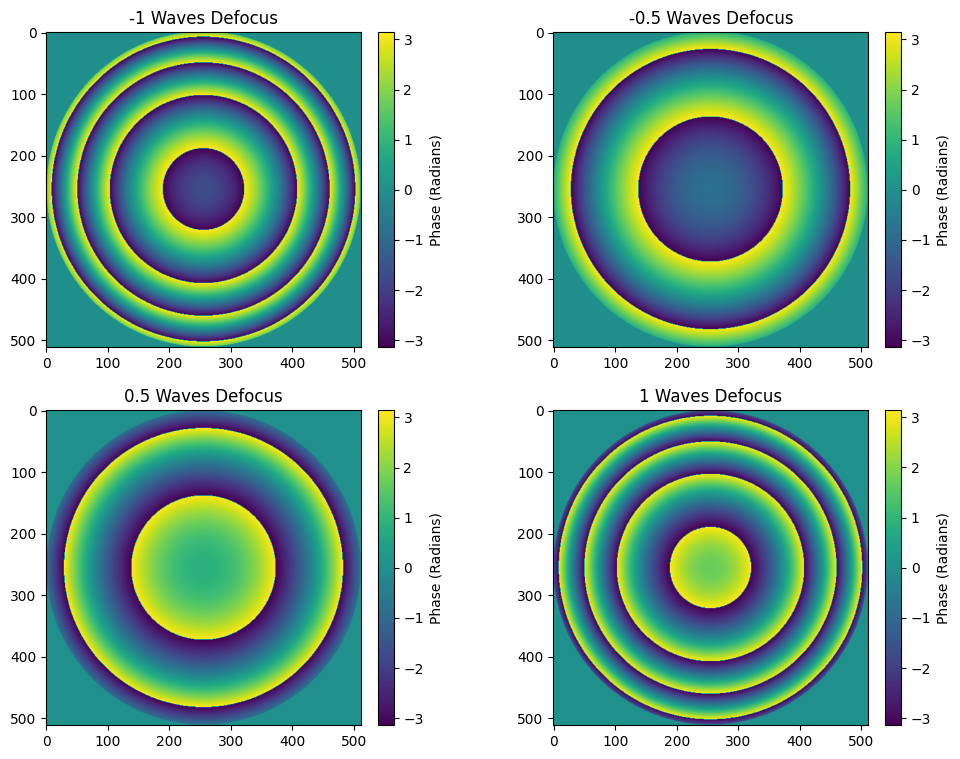

In [9]:
defocus_values = [-1, -0.5, 0.5, 1] # waves
probes = pr.get_defocus_probes(pupil, defocus_values) # get the wavefronts of different defocus magintudes

plt.figure(figsize=(12, 9))
plt.subplot(221)
plt.imshow(np.angle(probes[0])) # show the phase map of the defocus
plt.colorbar(fraction=0.046, pad=0.04, label='Phase (Radians)')
plt.title(str(defocus_values[0]) + ' Waves Defocus')
plt.subplot(222)
plt.imshow(np.angle(probes[1]))
plt.colorbar(fraction=0.046, pad=0.04, label='Phase (Radians)')
plt.title(str(defocus_values[1]) + ' Waves Defocus')
plt.subplot(223)
plt.imshow(np.angle(probes[2]))
plt.colorbar(fraction=0.046, pad=0.04, label='Phase (Radians)')
plt.title(str(defocus_values[2]) + ' Waves Defocus')
plt.subplot(224)
plt.imshow(np.angle(probes[3]))
plt.colorbar(fraction=0.046, pad=0.04, label='Phase (Radians)')
plt.title(str(defocus_values[3]) + ' Waves Defocus')
plt.show()

# Get OPD to estimate

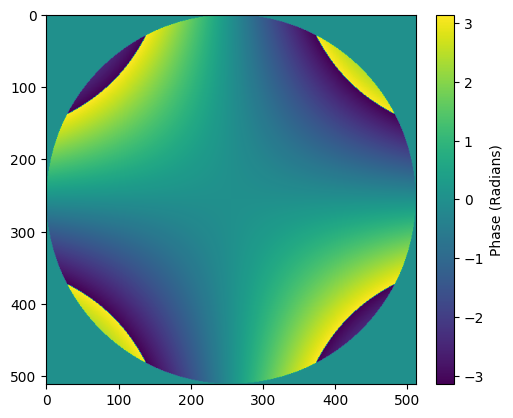

In [10]:
zernikes = pp.zernike.arbitrary_basis(pupil, nterms=11, outside=0) # give the bases of the first 11 zernike polynomials inside 'pupil', and set the data outside the mask to be 0
opd = np.exp(1j * zernikes[4] * 2 * np.pi * 0.25) # use 1/4 wave of zernike 5 as the OPD at the pupil

plt.imshow(np.angle(opd))
plt.colorbar(fraction=0.046, pad=0.04, label='Phase (Radians)')
plt.show()

# Use forward model to get PSFs

With a real system, this part is not needed since you will have real PSFs to work with. However, setting up the pupil mask needs to be handled differently. The phase retrieval code contains a "get_pupil_fit_mask" that should be used instead. Feel free to reach out if you have questions once you get there :)

In [11]:
focal_intensities, focal_efields, pupil_efields = pr.forward_model(pupil, probes, opd)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(focal_intensities[0])
plt.title(str(defocus_values[0]) + ' Waves Defocus')
plt.subplot(222)
plt.imshow(focal_intensities[1])
plt.title(str(defocus_values[1]) + ' Waves Defocus')
plt.subplot(223)
plt.imshow(focal_intensities[2])
plt.title(str(defocus_values[2]) + ' Waves Defocus')
plt.subplot(224)
plt.imshow(focal_intensities[3])
plt.title(str(defocus_values[3]) + ' Waves Defocus')
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\86159\.conda\envs\phase_retrieval_2\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\86159\AppData\Local\Temp\ipykernel_7596\1120691295.py", line 1, in <module>
    focal_intensities, focal_efields, pupil_efields = pr.forward_model(pupil, probes, opd)
  File "C:\Users\86159\Desktop\phase_retrieval_yiyanghuang\organized_functions.py", line 51, in forward_model
    xp = get_array_module(wavefront) # get the hardware used for data computation
  File "C:\Users\86159\Desktop\phase_retrieval_yiyanghuang\organized_functions.py", line 35, in get_array_module
    return cp.get_array_module(arr) # use 'get_array_module' in 'cupy' to check if 'arr' is on CPU (np) or GPU (cp)
  File "C:\Users\86159\.conda\envs\phase_retrieval_2\lib\site-packages\numpy\__init__.py", line 320, in __getattr__
    raise AttributeError("module {!r} has no attribute "
Attr

# Do phase retrieval

A couple notes: 
1. Setting "modes=None" will have the algorithm perform a zonal fit instead of a modal fit (with Zernikes in this case). You can tell the algorithm which modes to fit depending on what you send it. In this case it will fit the first 11 Zernike modes.
2. Setting "fit_amp=True" will fit pupil amplitude along with phase. Generally, keeping this set to false is fine as your pupil amplitude should be uniform enough for this to not matter.
3. "tol", "reg", and "wreg" do things when you change them. I have very little intuition as to what they do. I recommend playing around with the parameters to see what does/doesn't work.

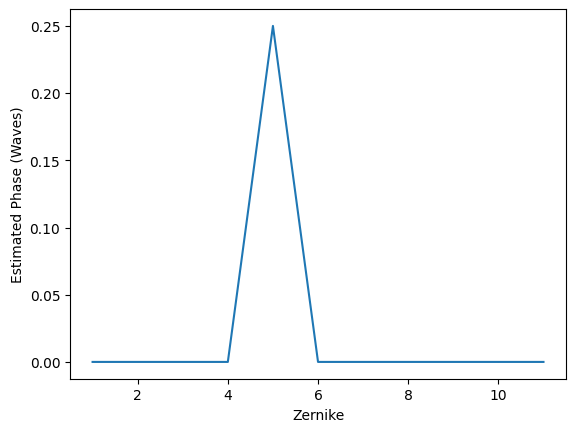

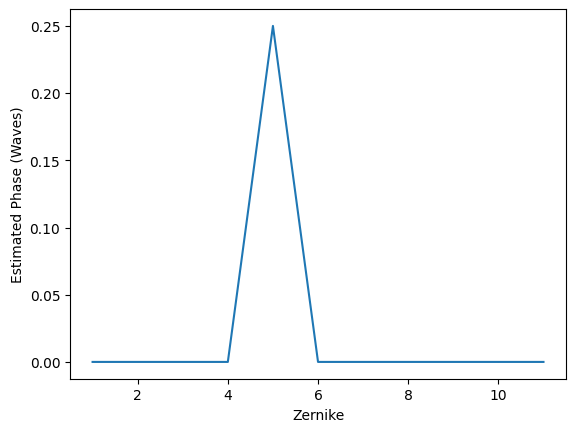

In [24]:
phase_retrieval_dict = pr.run_phase_retrieval(Imeas=focal_intensities, fitmask=pupil, Eprobes=probes, modes=zernikes, tol=1e-8, reg=0, wreg=1e3, fit_amp=False) 
estimated_coeffs = phase_retrieval_dict['fit_params'] # returns in units of radians

plt.figure()
plt.plot(np.arange(11) + 1, estimated_coeffs / 2 / np.pi)
plt.xlabel("Zernike")
plt.ylabel("Estimated Phase (Waves)")
plt.show()

When not using cupy, get rid of any ".get()"

In phase_retrieval.py: try not to use np or cp. Use xp instead

Check array shape: numpy.shape() gives matrix shape. type() gives the data type.